# Question 1

1a) In the long run prices will converge to the fundamental value. In the short run markets are like a voting machine, based on popularity, but in the long run, market is like a weighting machine, assessing fundamental economic values. Convergence to LR is not rapid/smooth annd near term expected returns are noisy.

1b) The predicting variables used  are returns = (DP) at time t + percentage change in PE + percentage change in Projit margin + sales growth per share. In the LR only DP at time t and sales growth per share remains, which is similar to the gordon growth formula

1c) GMO believes that values will converge back to the fundamental value. Thus, should they have forecasting a fall in PE multiples or Profit margins from current levels or when prices had deviated from fundamentals, the pricing formula will indicate a reversion back to fundamentals or a negative return for that period.

d) Managers are concerened with short term career risks rather than long term investnment performances. Therefore deviating from what most managers are doing is seen as a big risk, failing to cater to latest investor fad could also pay a significant professional price. 

2a) The PE ratio (valuation metric) stood at 19.9, higher than the long run average of 16. Skeptical that US firms could sustain the record profit margins they have delivered since 2009, and future earnings growth.
2b) Biggest driver for conditional forecast is the fall of P/E ratio back to 16 and the fall in profit margins to 6%.
2c) Mian difference is that P/E ratios have already fallen to 15 and the expected change in PE mulitples is 0, reducing the spread between the conditonal and unconditional real expected stock returns.

3a) U.S. equities

3b) Foreign govt bonds

3c) U.S. T bills

4a) Mostly US Fixed income at about 40-45% up to arounf 2001, switch to more international equities. US equities around 20-25%, and gradually increased nearer to 2003 from 2001 onwards.

b) Underperformed from 1997 to 1999 but outperformed benchmark from 2000 onwards

In [83]:
import numpy as np
import os
from arch import arch_model
import re
import sys
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
import sys
from typing import Tuple, Dict, Union, Callable
notebook_dir = "practice"
if os.path.basename(os.getcwd()) == notebook_dir:
    os.chdir(os.pardir)  # Change to parent directory
    sys.path.append(os.getcwd())  # Add the new current directory to sys.path

import cmds.portfolio_management_helper as pmh
import functions.functions_andy as fa
print(os.getcwd())

from sklearn.linear_model import LinearRegression
from dask.distributed import Client, wait
# From HW1
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from sklearn.metrics import r2_score
from scipy.stats import describe

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

c:\Users\Andik\OneDrive\Desktop\Chicago\Portfolio theory and risk management\githubrepo\finm-portfolio-2024


In [13]:
gmo_signals = pmh.read_excel_default(excel_name="./data/gmo_data.xlsx",
                                     sheet_name="signals")
gmo_rf = pmh.read_excel_default(excel_name="./data/gmo_data.xlsx",
                                sheet_name=2) / 12
gmo_funds = pmh.read_excel_default(excel_name="./data/gmo_data.xlsx",
                                      sheet_name=3)
gmo_signals.index = pd.to_datetime(gmo_signals.index)
gmo_rf.index = pd.to_datetime(gmo_rf.index)
gmo_funds.index = pd.to_datetime(gmo_funds.index)
display(gmo_signals.head())
display(gmo_rf.head())
display(gmo_funds.head())

gmo_funds_excess = gmo_funds.sub(gmo_rf.iloc[:, 0], axis=0)
gmo_funds_excess = gmo_funds_excess.dropna()
display(gmo_funds_excess.head())

subsamples = {"past_2011": gmo_funds_excess.loc[:'2011-12-31'],
              "2012_present": gmo_funds_excess.loc['2012-01-01':],
              "past_present": gmo_funds_excess}

statistics = {key: pmh.calc_summary_statistics(value).loc[:,["Annualized Mean", "Annualized Vol", "Annualized Sharpe","Min","Annualized Historical VaR (5.00%)","Max Drawdown"]].T for key, value in subsamples.items()}
display(pd.concat(statistics, axis=1))
# trial
def calc_stats(data, annual_factor =12, quantile = 0.05):
    stats = pd.DataFrame(index=data.columns)
    stats["Annualized Mean"] = data.mean()*annual_factor
    stats["Annualized Vol"] = data.std()*np.sqrt(annual_factor)
    stats["Annualized Sharpe"] = stats["Annualized Mean"]/stats["Annualized Vol"]
    stats["Min"] = data.min()
    stats["Annualized Historical VaR (5.00%)"] = data.quantile(quantile)*np.sqrt(annual_factor)
    stats["Max Drawdown"] = data.apply(lambda x: (1+x).cumprod().div((1+x).cumprod().cummax()).sub(1).min())
    return stats.T
stats_trial = {key: calc_stats(value) for key, value in subsamples.items()}
display(pd.concat(stats_trial, axis=1).T)

,SPX DVD YLD,SPX P/E,TNote 10YR
date,,,
1996-12-31,1.9651,19.6873,6.4180
1997-01-31,1.8455,20.8856,6.4940
1997-02-28,1.8502,21.0116,6.5520
1997-03-31,1.9427,18.4633,6.9030
1997-04-30,1.8430,19.6004,6.7180


,TBill 3M
date,
1996-12-31,0.0043
1997-01-31,0.0043
1997-02-28,0.0044
1997-03-31,0.0044
1997-04-30,0.0044


,SPY,GMWAX,GMGEX
date,,,
1996-12-31,-0.0233,-0.0221,-0.0130
1997-01-31,0.0618,0.0147,0.0344
1997-02-28,0.0096,0.0223,0.0127
1997-03-31,-0.0457,-0.0152,-0.0164
1997-04-30,0.0644,-0.0067,0.0000


,SPY,GMWAX,GMGEX
date,,,
1996-12-31,-0.0276,-0.0264,-0.0173
1997-01-31,0.0575,0.0104,0.0302
1997-02-28,0.0052,0.0179,0.0084
1997-03-31,-0.0502,-0.0196,-0.0209
1997-04-30,0.0600,-0.0111,-0.0044


Assuming monthly returns with annualization term of 12
Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"
Assuming monthly returns with annualization term of 12
Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"
Assuming monthly returns with annualization term of 12
Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


past_2011                 2012_present  \
                                        SPY   GMWAX   GMGEX          SPY   
Annualized Mean                      0.0358  0.0464 -0.0038       0.1330   
Annualized Vol                       0.1642  0.1105  0.1473       0.1412   
Annualized Sharpe                    0.2182  0.4201 -0.0260       0.9419   
Min                                 -0.1656 -0.1492 -0.1516      -0.1247   
Annualized Historical VaR (5.00%)   -0.2779 -0.1524 -0.2851      -0.2175   
Max Drawdown                        -0.5592 -0.3065 -0.5640      -0.2477   

                                                  past_present                  
                                    GMWAX   GMGEX          SPY   GMWAX   GMGEX  
Annualized Mean                    0.0434  0.0013       0.0805  0.0450 -0.0015  
Annualized Vol                     0.0949  0.2356       0.1545  0.1035  0.1926  
Annualized Sharpe                  0.4573  0.0056       0.5212  0.4352 -0.0076  
Min                               -0.1150 -0.6589      -0.1656 -0.1492 -0.6589  
Annualized Historical VaR (5.00%) -0.1415 -0.2357      -0.2760 -0.1433 -0.2640  
Max Drawdown                      -0.2256 -0.7383      -0.5592 -0.3065 -0.7681

Annualized Mean  Annualized Vol  Annualized Sharpe  \
past_2011    SPY             0.0358          0.1642             0.2182   
             GMWAX           0.0464          0.1105             0.4201   
             GMGEX          -0.0038          0.1473            -0.0260   
2012_present SPY             0.1330          0.1412             0.9419   
             GMWAX           0.0434          0.0949             0.4573   
             GMGEX           0.0013          0.2356             0.0056   
past_present SPY             0.0805          0.1545             0.5212   
             GMWAX           0.0450          0.1035             0.4352   
             GMGEX          -0.0015          0.1926            -0.0076   

                       Min  Annualized Historical VaR (5.00%)  Max Drawdown  
past_2011    SPY   -0.1656                            -0.2779       -0.5592  
             GMWAX -0.1492                            -0.1524       -0.3065  
             GMGEX -0.1516                            -0.2851       -0.5640  
2012_present SPY   -0.1247                            -0.2175       -0.2477  
             GMWAX -0.1150                            -0.1415       -0.2256  
             GMGEX -0.6589                            -0.2357       -0.7383  
past_present SPY   -0.1656                            -0.2760       -0.5592  
             GMWAX -0.1492                            -0.1433       -0.3065  
             GMGEX -0.6589                            -0.2640       -0.7681

In [17]:
def regress(y, X):
    if isinstance(X, pd.Series):
        X = X.to_frame()
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    beta = model.coef_[0][0]
    alpha = model.intercept_[0]
    r2 = model.score(X, y)
    return {"alpha": alpha, "beta": beta, "r2": r2}

regress_stats = {key: regress(X = value.loc[:,["SPY"]], y = value.loc[:,["GMWAX"]]) for key, value in subsamples.items()}
print("GMAWX vs SPY")
display(pd.DataFrame(regress_stats).T)
print("GMGEX vs SPY")
regress_stats = {key: regress(X = value.loc[:,["SPY"]], y = value.loc[:,["GMGEX"]]) for key, value in subsamples.items()}
display(pd.DataFrame(regress_stats).T)

GMAWX vs SPY


,alpha,beta,r2
past_2011,0.0023,0.5421,0.6487
2012_present,-0.0028,0.5818,0.7487
past_present,0.0000,0.5526,0.6802


GMGEX vs SPY


,alpha,beta,r2
past_2011,-0.0026,0.7642,0.7259
2012_present,-0.0092,0.8381,0.2525
past_present,-0.0054,0.7867,0.3979


In [41]:
# forecast regression
y =gmo_funds.loc[:,["SPY"]]
X = gmo_signals.shift(1)
display(pd.concat([y,X],axis=1).head())
full_data = pd.merge(y, X, left_index=True, right_index=True).dropna()
regressors = [["SPX DVD YLD"],["SPX P/E"],["SPX DVD YLD","SPX P/E","TNote 10YR"]]
regress_stats_data = {}
forecasted_data = {}
for cols in regressors:
    regress_result = pmh.calc_iterative_regression(multiple_y=y,X=X.loc[:,cols],annual_factor=12).T
    display(regress_result)
    regress_stats_data[",".join(cols)] = regress_result
    model = LinearRegression(fit_intercept=True)
    model.fit(full_data.loc[:,cols], full_data.loc[:,["SPY"]])
    forecasted_data[",".join(cols)] = model.predict(full_data.loc[:,cols]).flatten()
model = LinearRegression(fit_intercept=True)
model.fit(full_data.loc[:,["SPX DVD YLD","SPX P/E","TNote 10YR"]], full_data.loc[:,["SPY"]])
print("Coefficients")
print(model.coef_)
print("Intercept")
print(model.intercept_)
print("R2")
print(model.score(full_data.loc[:,["SPX DVD YLD","SPX P/E","TNote 10YR"]], full_data.loc[:,["SPY"]]))

,SPY,SPX DVD YLD,SPX P/E,TNote 10YR
date,,,,
1996-12-31,-0.0233,NaN,NaN,NaN
1997-01-31,0.0618,1.9651,19.6873,6.4180
1997-02-28,0.0096,1.8455,20.8856,6.4940
1997-03-31,-0.0457,1.8502,21.0116,6.5520
1997-04-30,0.0644,1.9427,18.4633,6.9030


"calc_regression" assumes excess returns to calculate Information and Treynor Ratios


,SPY
Alpha,-0.0110
Annualized Alpha,-0.1321
R-Squared,0.0094
SPX DVD YLD Beta,0.0108
Treynor Ratio,0.7875
Annualized Treynor Ratio,9.4503
Information Ratio,-0.2480
Annualized Information Ratio,-0.8589
Tracking Error,0.0444
Annualized Tracking Error,0.1538


"calc_regression" assumes excess returns to calculate Information and Treynor Ratios


,SPY
Alpha,0.0214
Annualized Alpha,0.2564
R-Squared,0.0039
SPX P/E Beta,-0.0006
Treynor Ratio,-13.1737
Annualized Treynor Ratio,-158.0849
Information Ratio,0.4800
Annualized Information Ratio,1.6627
Tracking Error,0.0445
Annualized Tracking Error,0.1542


"calc_regression" assumes excess returns to calculate Information and Treynor Ratios


,SPY
Alpha,-0.0154
Annualized Alpha,-0.1850
R-Squared,0.0102
SPX DVD YLD Beta,0.0118
SPX P/E Beta,0.0003
TNote 10YR Beta,-0.0007
Information Ratio,-0.3474
Annualized Information Ratio,-1.2034
Tracking Error,0.0444
Annualized Tracking Error,0.1537


Coefficients
[[ 0.01177149  0.00025749 -0.00069561]]
Intercept
[-0.01541419]
R2
0.010183638028190889


,SPX DVD YLD,SPX P/E,"SPX DVD YLD,SPX P/E,TNote 10YR"
date,,,
1997-01-31,0.0631,0.0535,0.0514
1997-02-28,0.0085,0.0075,0.0069
1997-03-31,-0.0410,-0.0357,-0.0330
1997-04-30,0.0642,0.0608,0.0477
1997-05-30,0.0562,0.0551,0.0421
...,...,...,...
2024-06-28,0.0131,0.0192,0.0136
2024-07-31,0.0040,0.0059,0.0045
2024-08-30,0.0076,0.0110,0.0093


Assuming excess returns were provided to calculate Sharpe. If returns were provided (steady of excess returns), the column "Sharpe" is actually "Mean/Volatility"


,SPX DVD YLD,SPX P/E,"SPX DVD YLD,SPX P/E,TNote 10YR"
Mean,0.0093,0.0082,0.0094
Annualized Mean,0.1112,0.0980,0.1130
Vol,0.0499,0.0415,0.0501
Annualized Vol,0.1728,0.1438,0.1736
Sharpe,0.1858,0.1969,0.1879
Annualized Sharpe,0.6435,0.6819,0.6510
Min,-0.2771,-0.1921,-0.2735
Max,0.2757,0.1441,0.2781
Skewness,-0.3042,-0.5072,-0.1620
Excess Kurtosis,9.9402,2.7349,9.5810


"calc_regression" assumes excess returns to calculate Information and Treynor Ratios


,SPX DVD YLD,SPX P/E,"SPX DVD YLD,SPX P/E,TNote 10YR"
Alpha,0.0011,0.0006,0.0013
Annualized Alpha,0.0134,0.0070,0.0154
R-Squared,0.7183,0.8981,0.7086
SPY Beta,0.9478,0.8819,0.9457
Treynor Ratio,0.0098,0.0093,0.0100
Annualized Treynor Ratio,0.1173,0.1112,0.1195
Information Ratio,0.0421,0.0442,0.0474
Annualized Information Ratio,0.1458,0.1531,0.1642
Tracking Error,0.0265,0.0133,0.0271
Annualized Tracking Error,0.0917,0.0459,0.0937


Text(0.5, 1.0, 'Cumulative Returns')

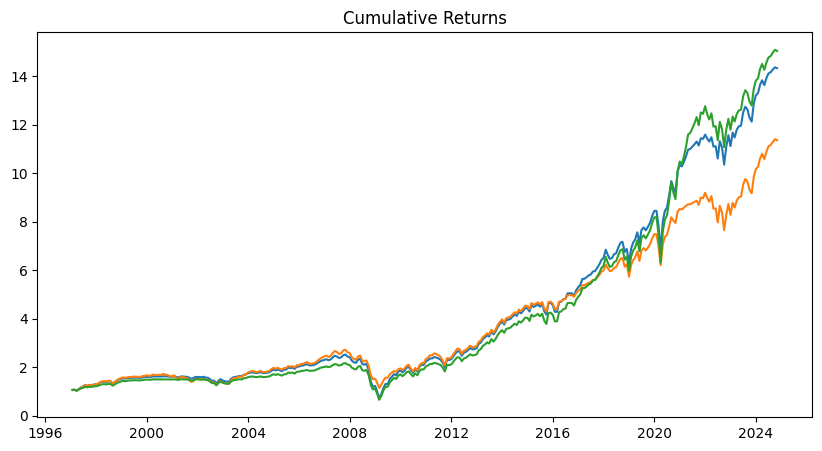

In [49]:
stats_df = pd.concat(regress_stats_data, axis=1).droplevel(1, axis=1)
forecasts_df_weights = pd.DataFrame(forecasted_data, index=full_data.index).apply(lambda x: x*100)
strat_returns = forecasts_df_weights.multiply(full_data.loc[:,["SPY"]].values, axis=0)
display(strat_returns)
display(pmh.calc_summary_statistics(strat_returns,annual_factor=12).T)
display(pmh.calc_iterative_regression(multiple_y=strat_returns,X=full_data.loc[:,["SPY"]],annual_factor=12).T)
plt.figure(figsize=(10,5))
plt.plot(strat_returns.index, (1+strat_returns).cumprod())
plt.title("Cumulative Returns")


,Value at risk (5%)
SPX DVD YLD,-0.0594
SPX P/E,-0.0651
"SPX DVD YLD,SPX P/E,TNote 10YR",-0.0620
SPY,-0.0761
GMWAX,-0.0406
GMGEX,-0.0757
TBill 3M,0.0000


0.4027777777777778


Text(0.5, 1.0, 'Cumulative Returns')

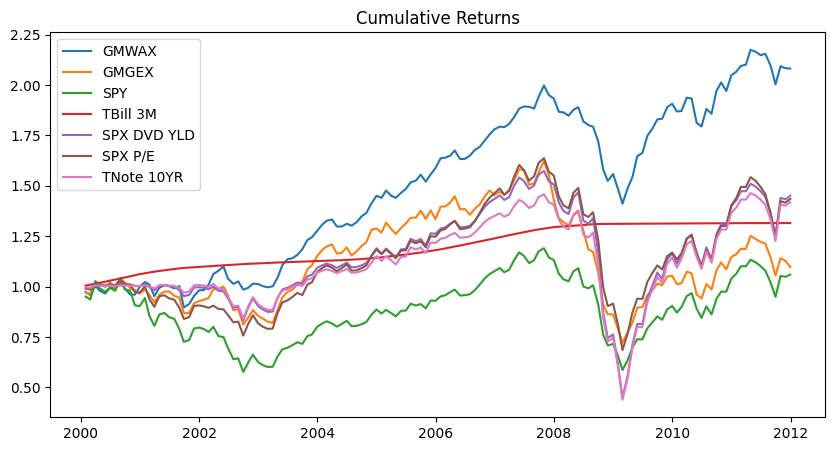

In [66]:
data = pd.merge(strat_returns, gmo_funds, left_index=True, right_index=True).merge(gmo_rf, left_index=True, right_index=True)
var = data.quantile(0.05)
display(var.to_frame('Value at risk (5%)'))

underperformance = data.loc[pd.to_datetime("2000-01-01"):pd.to_datetime("2011-12-31"),:].loc[data["GMWAX"]<data["TBill 3M"]].shape[0]/data.loc[pd.to_datetime("2000-01-01"):pd.to_datetime("2011-12-31"),:].shape[0]
print(underperformance)
data = data.loc[pd.to_datetime("2000-01-01"):pd.to_datetime("2011-12-31"),:]
plt.figure(figsize=(10,5))
plt.plot(data.index, (1+data["GMWAX"]).cumprod(), label="GMWAX")
plt.plot(data.index, (1+data["GMGEX"]).cumprod(), label="GMGEX")
plt.plot(data.index, (1+data["SPY"]).cumprod(), label="SPY")
plt.plot(data.index, (1+data["TBill 3M"]).cumprod(), label="TBill 3M")
plt.plot(data.index, (1+data["SPX DVD YLD"]).cumprod(), label="SPX DVD YLD")
plt.plot(data.index, (1+data["SPX P/E"]).cumprod(), label="SPX P/E")
plt.plot(data.index, (1+data["SPX DVD YLD,SPX P/E,TNote 10YR"]).cumprod(), label="TNote 10YR")
plt.legend()
plt.title("Cumulative Returns")


In [82]:
X = gmo_signals.loc[:,["SPX DVD YLD","SPX P/E"]].shift(1)
y = gmo_funds.loc[:,["SPY"]]
full_data= pd.merge(y, X, left_index=True, right_index=True).dropna()
display(full_data.head())
start_size = 60
test_size =1
forecasts_df = pd.DataFrame(index=full_data.index)
for i in range(start_size, len(full_data), test_size):
    train_data = full_data.iloc[:i]
    test_data = full_data.iloc[i:i+test_size]
    model = LinearRegression(fit_intercept=True)
    model.fit(train_data.loc[:,["SPX DVD YLD","SPX P/E"]], train_data.loc[:,["SPY"]])
    forecast = model.predict(test_data.loc[:,["SPX DVD YLD","SPX P/E"]]).flatten()
    # print(f"Actual: {test_data.loc[:,['SPY']].values[0][0]} Forecast: {forecast[0]}")
    # print(f"Error: {test_data.loc[:,['SPY']].values[0][0] - forecast[0]}")
    forecasts_df.loc[test_data.index, "Forecast"] = forecast
    forecasts_df.loc[test_data.index, "Actual"] = test_data.loc[:,["SPY"]].values.flatten()
    forecasts_df.loc[test_data.index, "Error"] = test_data.loc[:,["SPY"]].values.flatten() - forecast
forecasts_df = forecasts_df.dropna()
r2_score = r2_score(forecasts_df["Actual"], forecasts_df["Forecast"])
print(f"R2 Score: {r2_score}")

    


,SPY,SPX DVD YLD,SPX P/E
date,,,
1997-01-31,0.0618,1.9651,19.6873
1997-02-28,0.0096,1.8455,20.8856
1997-03-31,-0.0457,1.8502,21.0116
1997-04-30,0.0644,1.9427,18.4633
1997-05-30,0.0632,1.8430,19.6004


R2 Score: -0.07093292432139298


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns   
from sklearn.linear_model import LinearRegression
import os
import sys
from typing import Union
from functools import reduce
par_dir = "finm-portfolio-2024"
if os.path.basename(os.getcwd()) != par_dir:
    os.chdir(os.pardir)
    print(os.getcwd())

def load_data(filename, data_dir="data",sheet_name: Union[str, int] = 0) -> pd.DataFrame:
    file_path = os.path.join(data_dir, filename)
    data = pd.read_excel(file_path, sheet_name=sheet_name,parse_dates=True)
    data.set_index("date", inplace=True)
    print(f"NA/Nulls present in data: {data.isnull().sum().sum()}")
    return data

gmo_data = load_data("gmo_data.xlsx",sheet_name=3)
rf_data = load_data("gmo_data.xlsx",sheet_name=2)
signals_data = load_data("gmo_data.xlsx",sheet_name=1)
display(gmo_data.head())
display(rf_data.head())
display(signals_data.head())


c:\Users\Andik\OneDrive\Desktop\Chicago\Portfolio theory and risk management\githubrepo\finm-portfolio-2024
NA/Nulls present in data: 0
NA/Nulls present in data: 0
NA/Nulls present in data: 0


,SPY,GMWAX,GMGEX
date,,,
1996-12-31,-0.023292,-0.022094,-0.013000
1997-01-31,0.061786,0.014735,0.034448
1997-02-28,0.009565,0.022265,0.012733
1997-03-31,-0.045721,-0.015152,-0.016441
1997-04-30,0.064368,-0.006731,0.000000


,TBill 3M
date,
1996-12-31,0.05171
1997-01-31,0.05147
1997-02-28,0.05220
1997-03-31,0.05322
1997-04-30,0.05233


,SPX DVD YLD,SPX P/E,TNote 10YR
date,,,
1996-12-31,1.9651,19.6873,6.418
1997-01-31,1.8455,20.8856,6.494
1997-02-28,1.8502,21.0116,6.552
1997-03-31,1.9427,18.4633,6.903
1997-04-30,1.8430,19.6004,6.718


In [2]:
# convert to excess retruns
gmo_data = gmo_data.sub(rf_data["TBill 3M"], axis=0)
signals_data = signals_data.sub(rf_data["TBill 3M"], axis=0)

In [3]:
gmo_data.head()

,SPY,GMWAX,GMGEX
date,,,
1996-12-31,-0.075002,-0.073804,-0.064710
1997-01-31,0.010316,-0.036735,-0.017022
1997-02-28,-0.042635,-0.029935,-0.039467
1997-03-31,-0.098941,-0.068372,-0.069661
1997-04-30,0.012038,-0.059061,-0.052330


In [4]:
def calc_stats(df, annual_factor = 12, Var_quantile = 0.05):
    stats = pd.DataFrame()
    stats["mean"] = df.mean()
    stats["std"] = df.std()
    stats["sharpe"] = stats["mean"] / stats["std"] 
    stats["annual_mean"] = stats["mean"] * annual_factor
    stats["annual_std"] = stats["std"] * np.sqrt(annual_factor)
    stats["annual_sharpe"] = stats["sharpe"] * np.sqrt(annual_factor)
    stats["minimum_return"] = df.min()
    stats["Annualised VaR"] = df.quantile(Var_quantile) * np.sqrt(annual_factor)
    # max drawdown
    df_copy = (1 + df).cumprod()
    df_copy = (df_copy - df_copy.cummax()) / df_copy.cummax()
    stats["max_drawdown"] = df_copy.min()
    return stats

data = gmo_data.copy()
subsets = {"past_2011": data.loc[:pd.to_datetime("2011-12-31")],
           "2012_present": data.loc[pd.to_datetime("2012-01-01"):],
           "past_present": data}
stats = {key: calc_stats(subset) for key, subset in subsets.items()}
stats_df = pd.concat(stats, axis=0)
display(stats_df.loc[(slice(None),"GMWAX"),:])

,,mean,std,sharpe,annual_mean,annual_std,annual_sharpe,minimum_return,Annualised VaR,max_drawdown
past_2011,GMWAX,-0.022108,0.038067,-0.580759,-0.265291,0.131867,-2.011809,-0.193379,-0.290178,-0.988490
2012_present,GMWAX,-0.008850,0.032139,-0.275356,-0.106196,0.111332,-0.953862,-0.115577,-0.251070,-0.818206
past_present,GMWAX,-0.016013,0.036026,-0.444479,-0.192155,0.124798,-1.539722,-0.193379,-0.271931,-0.996149


GWMAX's mean excess returns (annualised) have been underperforming the risk free rate consistently, although in recent times performance has improved slightly (less negative excess returns). Its volatility remains close to constnt at about 3%.

## Question 2.2: For all three samples, analyze extreme scenario

In [5]:
display(stats_df.loc[(slice(None),"GMWAX"),["minimum_return","Annualised VaR","max_drawdown"]])

,,minimum_return,Annualised VaR,max_drawdown
past_2011,GMWAX,-0.193379,-0.290178,-0.988490
2012_present,GMWAX,-0.115577,-0.251070,-0.818206
past_present,GMWAX,-0.193379,-0.271931,-0.996149


a) GMWAX does not seem to have a high tail risk, Annualised value at risk is at about -0.25%, meaning the excess mean return above the risk free rate has a probability of 5% of being worst than 0.25% above the risk free rate. Max drawdown is also relatively small at about 0.9% on a monthly basis.

b) Does not vary much across 2 subsamples.

## Question 2.3:  Regress excess returns of GMWAX on excess returns of SPY

In [6]:
def regress(data, col, annual_factor = 12):
    y = data.loc[:,col].values.reshape(-1,1)
    X = data.loc[:,"SPY"].values.reshape(-1,1)
    model = LinearRegression(fit_intercept=True)
    model.fit(X,y)  
    # residuals = y - model.predict(X)
    Annualised_alpha = model.intercept_[0] * annual_factor
    beta = model.coef_[0][0]
    r2 = model.score(X,y)
    return {"Annualised_alpha": Annualised_alpha, "beta": beta, "r2": r2}

regressions = {key: regress(subset, col="GMWAX") for key, subset in subsets.items()}
regressions_df = pd.DataFrame(regressions).T
display(regressions_df)


,Annualised_alpha,beta,r2
past_2011,-0.094369,0.619535,0.687802
2012_present,-0.095545,0.641153,0.780285
past_present,-0.093859,0.627293,0.731836


b) No GMWAX is not a low beta strategy, with a beta of approx 0.6, and that remained nearly constant in all samples

c) alpha is negative, meaning it provides excess returns worst than that explained by the market, that has also been consistent in all subsamples.

## Question 2.4:   Compute the performance stats of 3.1-3.3 for GMGEX.

In [7]:
display(stats_df.loc[(slice(None),"GMGEX"),:])

,,mean,std,sharpe,annual_mean,annual_std,annual_sharpe,minimum_return,Annualised VaR,max_drawdown
past_2011,GMGEX,-0.026295,0.047481,-0.553793,-0.315536,0.164479,-1.918397,-0.176925,-0.331974,-0.995288
2012_present,GMGEX,-0.012359,0.069085,-0.178896,-0.148307,0.239316,-0.619714,-0.661188,-0.293776,-0.937019
past_present,GMGEX,-0.019888,0.058734,-0.338620,-0.238661,0.203459,-1.173016,-0.661188,-0.321580,-0.999424


In [8]:
data = gmo_data.copy()
subsets = {"past_2011": data.loc[:pd.to_datetime("2011-12-31")],
           "2012_present": data.loc[pd.to_datetime("2012-01-01"):],
           "past_present": data}
regressions = {key: regress(subset, col="GMGEX") for key, subset in subsets.items()}
regressions_df = pd.DataFrame(regressions).T
display(regressions_df)

,Annualised_alpha,beta,r2
past_2011,-0.090772,0.814692,0.764487
2012_present,-0.134610,0.824561,0.279303
past_present,-0.111706,0.810187,0.459311


The sensitivity to market is higher for that in GMGEX as compared to GMWAX. The volatility stats also show it is generally a riskier fund with higher tail risks.

# Question 3

In [9]:
gmo_data_raw = load_data("gmo_data.xlsx",sheet_name=3)
signals_data_raw = load_data("gmo_data.xlsx",sheet_name=1)
display(gmo_data_raw.head())
display(signals_data_raw.head())

NA/Nulls present in data: 0
NA/Nulls present in data: 0


,SPY,GMWAX,GMGEX
date,,,
1996-12-31,-0.023292,-0.022094,-0.013000
1997-01-31,0.061786,0.014735,0.034448
1997-02-28,0.009565,0.022265,0.012733
1997-03-31,-0.045721,-0.015152,-0.016441
1997-04-30,0.064368,-0.006731,0.000000


,SPX DVD YLD,SPX P/E,TNote 10YR
date,,,
1996-12-31,1.9651,19.6873,6.418
1997-01-31,1.8455,20.8856,6.494
1997-02-28,1.8502,21.0116,6.552
1997-03-31,1.9427,18.4633,6.903
1997-04-30,1.8430,19.6004,6.718


In [10]:
# Run regression
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LinearRegression
import pandas as pd

def linear_model_lagged(data: pd.DataFrame, cols, target_col: str, annual_factor: int = 12):
    data = data.copy()
    
    # Ensure cols is a list
    if isinstance(cols, str):
        cols = [cols]
    
    # Create lagged versions of all columns specified
    for col in cols:
        data[f'lagged_{col}'] = data[col].shift(1)
    
    # Drop rows with NaN values that were introduced by shifting
    data.dropna(inplace=True)
    
    # Set up the target and predictors
    y = data[target_col].values.reshape(-1, 1)
    X = data[[f'lagged_{col}' for col in cols]].values
    
    # Fit the linear regression model
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    residuals = y - model.predict(X)
    Annualised_alpha = model.intercept_[0] * annual_factor
    beta = model.coef_[0]
    r2 = model.score(X, y)
    
    # Organize results in a DataFrame
    results = pd.DataFrame({
        "Annualised_alpha": Annualised_alpha,
        "beta": beta,
        "r2": r2,
        "predictors": cols
    })
    
    return results

combined_data = pd.concat([gmo_data_raw, signals_data_raw], axis=1)
for cols in ["SPX DVD YLD", "SPX P/E", ["SPX DVD YLD", "SPX P/E", "TNote 10YR"]]:
    DP_model_results = linear_model_lagged(combined_data, cols=cols, target_col="SPY")
    display(DP_model_results)



    




,Annualised_alpha,beta,r2,predictors
0,-0.132069,0.0108,0.009422,SPX DVD YLD


,Annualised_alpha,beta,r2,predictors
0,0.256374,-0.000646,0.0039,SPX P/E


,Annualised_alpha,beta,r2,predictors
0,-0.18497,0.011771,0.010184,SPX DVD YLD
1,-0.18497,0.000257,0.010184,SPX P/E
2,-0.18497,-0.000696,0.010184,TNote 10YR


In [11]:
# utilize for trading strategy
combined_data.head()

,SPY,GMWAX,GMGEX,SPX DVD YLD,SPX P/E,TNote 10YR
date,,,,,,
1996-12-31,-0.023292,-0.022094,-0.013000,1.9651,19.6873,6.418
1997-01-31,0.061786,0.014735,0.034448,1.8455,20.8856,6.494
1997-02-28,0.009565,0.022265,0.012733,1.8502,21.0116,6.552
1997-03-31,-0.045721,-0.015152,-0.016441,1.9427,18.4633,6.903
1997-04-30,0.064368,-0.006731,0.000000,1.8430,19.6004,6.718


In [12]:
combined_data2 = combined_data.apply(lambda x: x.shift(1) if x.name in ["SPX DVD YLD", "SPX P/E", "TNote 10YR"] else x).dropna()
print(combined_data.index)
model_dp = LinearRegression(fit_intercept=True)
model_dp = model_dp.fit(combined_data2[["SPX DVD YLD"]].values,combined_data2["SPY"].values.reshape(-1,1))
model_ep = LinearRegression(fit_intercept=True)
model_ep = model_ep.fit(combined_data2[["SPX P/E"]].values,combined_data2["SPY"].values.reshape(-1,1))
model_all = LinearRegression(fit_intercept=True)
model_all = model_all.fit(combined_data2[["SPX DVD YLD","SPX P/E","TNote 10YR"]].values,combined_data2["SPY"].values.reshape(-1,1))
combined_data2 = combined_data2.assign(forecasted_spy_dp = model_dp.predict(combined_data2[["SPX DVD YLD"]].values))
combined_data2 = combined_data2.assign(forecasted_spy_ep = model_ep.predict(combined_data2[["SPX P/E"]].values))
combined_data2 = combined_data2.assign(forecasted_spy_all = model_all.predict(combined_data2[["SPX DVD YLD","SPX P/E","TNote 10YR"]].values))
display(combined_data2.head())

# investments

combined_data2 = combined_data2.apply(lambda x: x*100 if x.name in ["forecasted_spy_dp","forecasted_spy_ep","forecasted_spy_all"] else x).rename(columns= {"forecasted_spy_dp":"allocated_dp","forecasted_spy_ep":"allocated_ep","forecasted_spy_all":"allocated_all"})
print(combined_data2[["allocated_dp","allocated_ep","allocated_all"]].index)
# return_strategy = combined_data[["allocated_dp","allocated_ep","allocated_all"]].apply(lambda x: x.shift(-1) * gmo_data_raw["SPY"])
# display(return_strategy.head())
print(gmo_data_raw.index[:-1])

return_strategy = combined_data2.loc[:,["allocated_dp","allocated_ep","allocated_all"]].set_index(gmo_data_raw.index[:-1]) 
strategy_return = return_strategy.apply(lambda x:  x * gmo_data_raw["SPY"]).shift(1).dropna()

DatetimeIndex(['1996-12-31', '1997-01-31', '1997-02-28', '1997-03-31',
               '1997-04-30', '1997-05-30', '1997-06-30', '1997-07-31',
               '1997-08-29', '1997-09-30',
               ...
               '2024-01-31', '2024-02-29', '2024-03-29', '2024-04-30',
               '2024-05-31', '2024-06-28', '2024-07-31', '2024-08-30',
               '2024-09-30', '2024-10-31'],
              dtype='datetime64[ns]', name='date', length=335, freq=None)


,SPY,GMWAX,GMGEX,SPX DVD YLD,SPX P/E,TNote 10YR,forecasted_spy_dp,forecasted_spy_ep,forecasted_spy_all
date,,,,,,,,,
1997-01-31,0.061786,0.014735,0.034448,1.9651,19.6873,6.418,0.010217,0.008654,0.008323
1997-02-28,0.009565,0.022265,0.012733,1.8455,20.8856,6.494,0.008926,0.007880,0.007171
1997-03-31,-0.045721,-0.015152,-0.016441,1.8502,21.0116,6.552,0.008976,0.007799,0.007218
1997-04-30,0.064368,-0.006731,0.000000,1.9427,18.4633,6.903,0.009975,0.009444,0.007407
1997-05-30,0.063207,0.057115,0.058014,1.8430,19.6004,6.718,0.008899,0.008710,0.006654


DatetimeIndex(['1997-01-31', '1997-02-28', '1997-03-31', '1997-04-30',
               '1997-05-30', '1997-06-30', '1997-07-31', '1997-08-29',
               '1997-09-30', '1997-10-31',
               ...
               '2024-01-31', '2024-02-29', '2024-03-29', '2024-04-30',
               '2024-05-31', '2024-06-28', '2024-07-31', '2024-08-30',
               '2024-09-30', '2024-10-31'],
              dtype='datetime64[ns]', name='date', length=334, freq=None)
DatetimeIndex(['1996-12-31', '1997-01-31', '1997-02-28', '1997-03-31',
               '1997-04-30', '1997-05-30', '1997-06-30', '1997-07-31',
               '1997-08-29', '1997-09-30',
               ...
               '2023-12-29', '2024-01-31', '2024-02-29', '2024-03-29',
               '2024-04-30', '2024-05-31', '2024-06-28', '2024-07-31',
               '2024-08-30', '2024-09-30'],
              dtype='datetime64[ns]', name='date', length=334, freq=None)


In [13]:
display(strategy_return)
return_stats = calc_stats(strategy_return)
def regress(spy, data, col, annual_factor = 12):
    y = data.loc[:,col].values.reshape(-1,1)
    X = spy.values.reshape(-1,1)
    model = LinearRegression(fit_intercept=True)
    model.fit(X,y)  
    residuals = y - model.predict(X)
    Annualised_alpha = model.intercept_[0] * annual_factor
    beta = model.coef_[0][0]
    r2 = model.score(X,y)
    information_ratio = np.mean(residuals) / np.std(residuals) * np.sqrt(annual_factor)
    treynor_ratio = np.mean(y) / beta
    results_df = pd.DataFrame({"Annualised_alpha": Annualised_alpha, "beta": beta, "r2": r2, "information_ratio": information_ratio, "treynor_ratio": treynor_ratio}, index=[col])
    return results_df

for col in ["allocated_dp","allocated_ep","allocated_all"]:
    display(regress(gmo_data_raw["SPY"].shift(1).dropna(),strategy_return, col=col))

,allocated_dp,allocated_ep,allocated_all
date,,,
1997-01-31,-0.023798,-0.020157,-0.019386
1997-02-28,0.055148,0.048690,0.044304
1997-03-31,0.008586,0.007460,0.006904
1997-04-30,-0.045608,-0.043180,-0.033863
1997-05-30,0.057279,0.056065,0.042833
...,...,...,...
2024-06-28,0.018794,0.027577,0.019465
2024-07-31,0.011739,0.017206,0.013146
2024-08-30,0.003942,0.005703,0.004806


,Annualised_alpha,beta,r2,information_ratio,treynor_ratio
allocated_dp,-0.041107,0.988388,0.715153,-3.003762e-16,0.005092


,Annualised_alpha,beta,r2,information_ratio,treynor_ratio
allocated_ep,-0.024028,0.892295,0.89424,-1.473866e-16,0.006313


,Annualised_alpha,beta,r2,information_ratio,treynor_ratio
allocated_all,-0.032939,0.988609,0.710391,-2.558936e-16,0.005781


In [14]:
# 3a
gmo_data_raw.apply(lambda x: x.quantile(0.05) * np.sqrt(12)).to_frame("Annualised VaR")


,Annualised VaR
SPY,-0.262936
GMWAX,-0.140542
GMGEX,-0.262190


In [15]:
display(strategy_return.apply(lambda x: x.quantile(0.05) * np.sqrt(12)).to_frame("Annualised VaR"))

,Annualised VaR
allocated_dp,-0.240532
allocated_ep,-0.243649
allocated_all,-0.252088


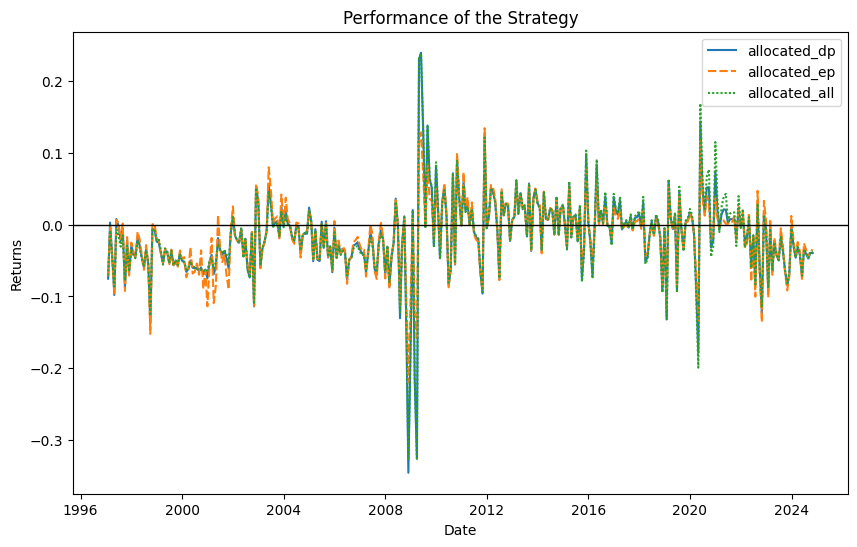

,Frequency of Losing Months
allocated_dp,0.646707
allocated_ep,0.604790
allocated_all,0.652695


In [16]:
merged_data = rf_data.merge(strategy_return, left_index=True, right_index=True)
performance_data = pd.DataFrame(index= merged_data.index)
performance_data = merged_data.apply(lambda x:x - merged_data["TBill 3M"] if x.name != "TBill 3M" else x)
performance_data = performance_data.drop(columns="TBill 3M")
# Plot Does it beat the risk free rate
plt.figure(figsize=(10,6))
sns.lineplot(data=performance_data)
# Horizontal line for 0
plt.axhline(0, color='black', lw=1)
plt.title("Performance of the Strategy")
plt.ylabel("Returns")
plt.xlabel("Date")
plt.show()

# Frequency of losign months
performance_data.apply(lambda x: x < 0).mean().to_frame("Frequency of Losing Months")

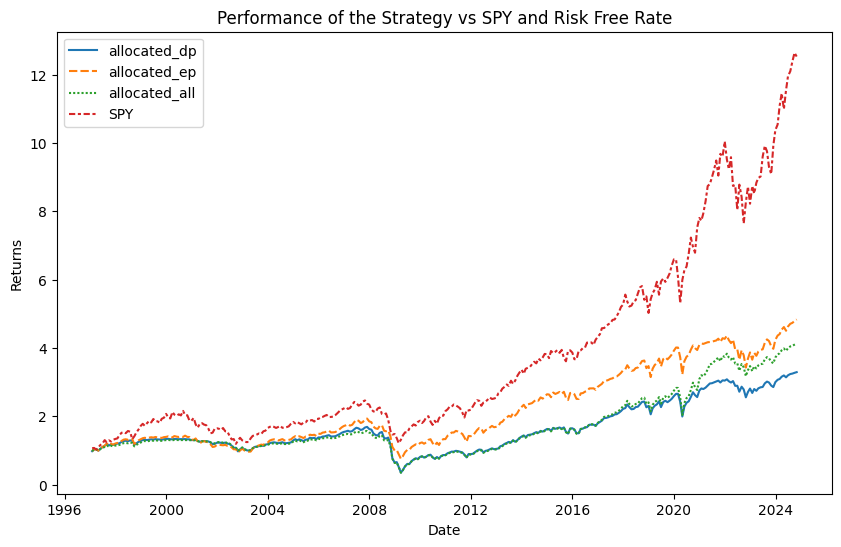

In [17]:
# plot strategy returns and spy and risk free rate
plt.figure(figsize=(10,6))
sns.lineplot(data=(1+strategy_return.merge(gmo_data_raw["SPY"], left_index=True, right_index=True)).cumprod())
plt.title("Performance of the Strategy vs SPY and Risk Free Rate")
plt.ylabel("Returns")
plt.xlabel("Date")
plt.show()

In [18]:
#OOS forecasting
OOS_GMO = gmo_data_raw.copy()
display(OOS_GMO.head())
display(signals_data_raw.head())
display(rf_data.head())

,SPY,GMWAX,GMGEX
date,,,
1996-12-31,-0.023292,-0.022094,-0.013000
1997-01-31,0.061786,0.014735,0.034448
1997-02-28,0.009565,0.022265,0.012733
1997-03-31,-0.045721,-0.015152,-0.016441
1997-04-30,0.064368,-0.006731,0.000000


,SPX DVD YLD,SPX P/E,TNote 10YR
date,,,
1996-12-31,1.9651,19.6873,6.418
1997-01-31,1.8455,20.8856,6.494
1997-02-28,1.8502,21.0116,6.552
1997-03-31,1.9427,18.4633,6.903
1997-04-30,1.8430,19.6004,6.718


,TBill 3M
date,
1996-12-31,0.05171
1997-01-31,0.05147
1997-02-28,0.05220
1997-03-31,0.05322
1997-04-30,0.05233


In [26]:
full_dataset = pd.concat([OOS_GMO, signals_data_raw, rf_data], axis=1)
full_dataset = full_dataset.assign(Excess_SPY = full_dataset["SPY"] - full_dataset["TBill 3M"],
                                   Excess_GMWAX = full_dataset["GMWAX"] - full_dataset["TBill 3M"],
                                   Excess_GMGEX = full_dataset["GMGEX"] - full_dataset["TBill 3M"])

display(full_dataset.tail())

t = 60
annual_factor = 12
window = 1
full_dataset_subset = full_dataset.iloc[t:,:].apply(lambda x: x.shift(1) if x.name in ["SPX DVD YLD", "SPX P/E", "TNote 10YR"] else x).dropna()
X = full_dataset_subset[["SPX DVD YLD","SPX P/E"]]
y = full_dataset_subset[["SPY"]]
model = LinearRegression(fit_intercept=True)
model = model.fit(X,y)
r2 = model.score(X,y)
alpha = model.intercept_[0]
beta = model.coef_[0][0]
annualised_alpha = alpha * 12
stats = {"Annualised Alpha": annualised_alpha, "Beta": beta, "R2": r2}
prediction = model.predict(full_dataset[["SPX DVD YLD","SPX P/E"]].iloc[t+window,:].to_frame().T)[0][0]

OOS_predictions = pd.DataFrame(index=full_dataset.index[t+window:])
null_predictions = pd.DataFrame(index=OOS_predictions.index)
OOS_strat_predictions = pd.DataFrame(index=OOS_predictions.index)
train_end_index_list = full_dataset.index[t:-window:window]
test_index_list = full_dataset.index[t+window::window]
beta_list = [0]*3
alpha_list = [0]*3
r2_list = [0]*3
annualised_alpha_list = [0]*3

print(train_end_index_list)
print(len(train_end_index_list))
print(len(test_index_list))
for i in range(len(train_end_index_list)):
    train_end_index = train_end_index_list[i]
    test_index = test_index_list[i]
    full_dataset_subset = full_dataset.loc[:train_end_index].apply(lambda x: x.shift(1) if x.name in ["SPX DVD YLD", "SPX P/E", "TNote 10YR"] else x).dropna()
    X = full_dataset_subset[["SPX DVD YLD","SPX P/E"]]
    y = full_dataset_subset[["SPY"]]
    null_predictions.loc[test_index,"Null Prediction"] = y.mean()[0]
    model = LinearRegression(fit_intercept=True)
    model = model.fit(X,y)
    r2 = model.score(X,y)
    alpha = model.intercept_[0]
    beta = model.coef_[0][0]
    annualised_alpha = alpha * 12
    beta_list.append(beta)
    alpha_list.append(alpha)
    r2_list.append(r2)
    annualised_alpha_list.append(annualised_alpha)
    test_data =full_dataset[["SPX DVD YLD","SPX P/E"]].loc[test_index].to_frame().T
    prediction = model.predict(test_data)[0][0]
    OOS_predictions.loc[test_index,"OOS Prediction"] = prediction
    weight = prediction * 100
    OOS_strat_predictions.loc[test_index,"Strat_prediction"] = weight * test_data.values[0][0]
all_predictioons = pd.concat([OOS_predictions, null_predictions, OOS_strat_predictions,full_dataset["SPY"].iloc[t+window:]], axis=1)
display(all_predictioons)

,SPY,GMWAX,GMGEX,SPX DVD YLD,SPX P/E,TNote 10YR,TBill 3M,Excess_SPY,Excess_GMWAX,Excess_GMGEX
date,,,,,,,,,,
2024-06-28,0.035285,-0.007192,-0.013083,1.3271,25.5386,4.3961,0.053549,-0.018264,-0.060741,-0.066632
2024-07-31,0.012109,0.030400,0.034681,1.3205,25.7965,4.0296,0.052840,-0.040731,-0.022440,-0.018159
2024-08-30,0.023366,0.014694,0.019542,1.2990,25.5680,3.9034,0.051117,-0.027751,-0.036423,-0.031575
2024-09-30,0.021009,0.012437,0.015359,1.2789,26.1183,3.7809,0.046169,-0.025160,-0.033732,-0.030810
2024-10-31,-0.008924,-0.036908,-0.039505,1.3046,25.8491,4.2844,0.045418,-0.054342,-0.082326,-0.084923


DatetimeIndex(['2001-12-31', '2002-01-31', '2002-02-28', '2002-03-29',
               '2002-04-30', '2002-05-31', '2002-06-28', '2002-07-31',
               '2002-08-30', '2002-09-30',
               ...
               '2023-12-29', '2024-01-31', '2024-02-29', '2024-03-29',
               '2024-04-30', '2024-05-31', '2024-06-28', '2024-07-31',
               '2024-08-30', '2024-09-30'],
              dtype='datetime64[ns]', name='date', length=274, freq=None)
274
274


C:\Users\Andik\AppData\Local\Temp\ipykernel_11712\3648297066.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_predictions.loc[test_index,"Null Prediction"] = y.mean()[0]
C:\Users\Andik\AppData\Local\Temp\ipykernel_11712\3648297066.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  null_predictions.loc[test_index,"Null Prediction"] = y.mean()[0]
C:\Users\Andik\AppData\Local\Temp\ipykernel_11712\3648297066.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value

,OOS Prediction,Null Prediction,Strat_prediction,SPY
date,,,,
2002-01-31,0.012740,0.009647,1.748954,-0.009798
2002-02-28,0.019595,0.009328,2.748837,-0.017937
2002-03-29,0.016841,0.008888,2.287968,0.033243
2002-04-30,0.022620,0.009275,3.278712,-0.058155
2002-05-31,0.019911,0.008221,2.925721,-0.005933
...,...,...,...,...
2024-06-28,0.003291,0.008479,0.436806,0.035285
2024-07-31,0.003534,0.008561,0.466725,0.012109
2024-08-30,0.003261,0.008571,0.423569,0.023366


In [33]:
def calc_stats(df, annual_factor = 12, Var_quantile = 0.05):
    stats = pd.DataFrame()
    stats["mean"] = df.mean()
    stats["std"] = df.std()
    stats["sharpe"] = stats["mean"] / stats["std"] 
    stats["annual_mean"] = stats["mean"] * annual_factor
    stats["annual_std"] = stats["std"] * np.sqrt(annual_factor)
    stats["annual_sharpe"] = stats["sharpe"] * np.sqrt(annual_factor)
    stats["minimum_return"] = df.min()
    stats["Annualised VaR"] = df.quantile(Var_quantile) * np.sqrt(annual_factor)
    # max drawdown
    df_copy = (1 + df).cumprod()
    df_copy = (df_copy - df_copy.cummax()) / df_copy.cummax()
    stats["max_drawdown"] = df_copy.min()
    return stats

def regress_stats(df, target_col, annual_factor = 12):
    y = df.loc[:,target_col].values.reshape(-1,1)
    X = df.loc[:,"SPY"].values.reshape(-1,1)
    model = LinearRegression(fit_intercept=True)
    model.fit(X,y)  
    residuals = y - model.predict(X)
    Annualised_alpha = model.intercept_[0] * annual_factor
    beta = model.coef_[0][0]
    r2 = model.score(X,y)
    information_ratio = np.mean(residuals) / np.std(residuals) * np.sqrt(annual_factor)
    treynor_ratio = np.mean(y) / beta
    stats = {"Annualised_alpha": Annualised_alpha, "beta": beta, "r2": r2, "information_ratio": information_ratio, "treynor_ratio": treynor_ratio}
    return stats

prediction_stats_df= calc_stats(all_predictioons)
additional_data = pd.DataFrame({col:regress_stats(all_predictioons,col) for col in all_predictioons.columns})
prediction_stats_df = prediction_stats_df.merge(additional_data.T, left_index=True, right_index=True)
display(prediction_stats_df)

,mean,std,sharpe,annual_mean,annual_std,annual_sharpe,minimum_return,Annualised VaR,max_drawdown,Annualised_alpha,beta,r2,information_ratio,treynor_ratio
OOS Prediction,0.010212,0.009810,1.040986,0.122546,0.033983,3.606081,-0.059210,0.009967,-1.752096e-01,1.259690e-01,-0.034074,0.022483,2.899607e-16,-0.299701
Null Prediction,0.006912,0.001206,5.732089,0.082946,0.004177,19.856539,0.002424,0.015847,0.000000e+00,8.316933e-02,-0.002226,0.006352,1.608537e-15,-3.104784
Strat_prediction,1.823853,2.548350,0.715700,21.886241,8.827744,2.479257,-21.249153,1.456522,-5.543391e+65,2.256890e+01,-6.795654,0.013252,2.844147e-16,-0.268385
SPY,0.008371,0.043169,0.193921,0.100456,0.149541,0.671761,-0.165187,-0.261632,-5.079762e-01,-4.163336e-17,1.000000,1.000000,-1.411404e-01,0.008371


import yfinance as yf

data_psx = yf.download("PSX", end="2024-12-31")
data_psx = data_psx["Adj Close"].pct_change()
data_spy = yf.download("SPY", end="2024-12-31")
data_spy = data_spy["Adj Close"].pct_change()
data_sector = yf.download("XLE", end="2024-12-31")



import yfinance as yf
import pandas as pd
import numpy as np

# Fetching the data for PSX and SPY
data_psx = yf.download("PSX", end="2024-12-31")['Adj Close'].resample('M').last().pct_change()
data_spy = yf.download("SPY", end="2024-12-31")['Adj Close'].resample('M').last().pct_change()

# Fetching the sector data, using yfinance for Energy sector ETF 'XLE' as a proxy
data_sector = yf.download("XLE", end="2024-12-31")['Adj Close'].resample('M').last().pct_change()

# Getting Treasury bill data from FRED (using 'DTB3' - 3 Month Treasury Bill as a proxy)
from pandas_datareader import data as pdr

# Adjust date format for compatibility with FRED
start_date = '2020-01-01'
end_date = '2024-12-31'

rf_rate = pdr.get_data_fred('DTB3', start_date, end_date)
rf_rate_monthly = rf_rate.resample('M').last().pct_change()

# Concatenating all data into a single DataFrame
all_data = pd.concat([data_psx, data_spy, data_sector, rf_rate_monthly], axis=1)
all_data.columns = ['PSX', 'SPY', 'Sector', 'RF']

# Calculating excess returns
all_data['Excess PSX'] = all_data['PSX'] - all_data['RF']
all_data['Excess SPY'] = all_data['SPY'] - all_data['RF']

all_data.dropna(inplace=True)  # Drop NA values for clean dataset

# Now we perform the analysis using the helper function provided
def calc_stats(df, annual_factor = 12, Var_quantile = 0.05):
    stats = pd.DataFrame()
    stats["mean"] = df.mean()
    stats["std"] = df.std()
    stats["sharpe"] = stats["mean"] / stats["std"] 
    stats["annual_mean"] = stats["mean"] * annual_factor
    stats["annual_std"] = stats["std"] * np.sqrt(annual_factor)
    stats["annual_sharpe"] = stats["sharpe"] * np.sqrt(annual_factor)
    stats["minimum_return"] = df.min()
    stats["Annualised VaR"] = df.quantile(Var_quantile) * np.sqrt(annual_factor)
    # max drawdown calculation
    df_copy = (1 + df).cumprod()
    df_copy = (df_copy - df_copy.cummax()) / df_copy.cummax()
    stats["max_drawdown"] = df_copy.min()
    return stats

# Applying statistics calculation on Excess returns
stats_psx = calc_stats(all_data[['Excess PSX', 'Excess SPY']])
stats_psx


import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas_datareader import data as pdr

def calc_stats(df, annual_factor=12, Var_quantile=0.05):
    stats = pd.DataFrame(index=df.columns)
    stats["mean"] = df.mean() * annual_factor
    stats["std"] = df.std() * np.sqrt(annual_factor)
    stats["sharpe"] = stats["mean"] / stats["std"]
    stats["minimum_return"] = df.min()
    stats["annualised_Var"] = df.quantile(Var_quantile) * np.sqrt(annual_factor)
    df_cum = (1 + df).cumprod()
    drawdown = df_cum / df_cum.cummax() - 1
    stats["max_drawdown"] = drawdown.min()
    return stats

def analyze_stock(symbol):
    # Download stock and SPY data
    data_stock = yf.download(symbol, end="2024-12-31")['Adj Close'].resample('M').last().pct_change()
    data_spy = yf.download("SPY", end="2024-12-31")['Adj Close'].resample('M').last().pct_change()

    # Fetch 3 Month Treasury Bill as risk-free rate
    rf_rate = pdr.get_data_fred('DTB3', '2020-01-01', '2024-12-31').resample('M').last().pct_change()

    # Create a DataFrame
    data = pd.concat([data_stock, data_spy, rf_rate], axis=1)
    data.columns = [symbol, 'SPY', 'RF']
    data.dropna(inplace=True)

    # Calculate excess returns
    data['Excess ' + symbol] = data[symbol] - data['RF']
    data['Excess SPY'] = data['SPY'] - data['RF']

    # Linear regression to find alpha and beta
    X = sm.add_constant(data['Excess SPY'])  # Adding a constant for intercept
    model = sm.OLS(data['Excess ' + symbol], X).fit()
    beta = model.params['Excess SPY']
    alpha = model.params['const']

    # Annualize alpha
    annual_alpha = alpha * 12

    # Calculate Treynor and Information Ratios
    treynor_ratio = (data['Excess ' + symbol].mean() * 12) / beta
    tracking_error = (data['Excess ' + symbol] - data['Excess SPY']).std() * np.sqrt(12)
    information_ratio = (annual_alpha / tracking_error)

    # Calculate additional statistics
    stock_stats = calc_stats(data[[symbol, 'Excess ' + symbol]], annual_factor=12)

    # Summary
    print(f"Analysis for {symbol}:")
    print(f"Beta: {beta:.4f}")
    print(f"Annualized Alpha: {annual_alpha:.4f}")
    print(f"Treynor Ratio: {treynor_ratio:.4f}")
    print(f"Information Ratio: {information_ratio:.4f}")
    print("\nStatistical Measures:\n", stock_stats)
    print("\nRegression Model Summary:\n", model.summary())
    print("\n")

# Example usage
analyze_stock("PSX")  # Phillips 66
analyze_stock("DE")   # Deere & Company
analyze_stock("LAD")  # Lithia Motors, Inc.


import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr

def fetch_financial_data(stock_symbol):
    # Define the end date for the data download
    end_date = "2024-12-31"

    # Download stock data
    stock_data = yf.Ticker(stock_symbol)
    hist_data = stock_data.history(period="max").resample('M').last()

    # Convert all datetime indices to timezone-naive (if necessary)
    if hist_data.index.tz is not None:
        hist_data.index = hist_data.index.tz_localize(None)
    
    # Financial ratios
    pe_ratio = stock_data.info.get('trailingPE', None)  # Price/Earnings ratio
    earnings_sales = stock_data.info.get('grossMargins', None)  # Gross margins as proxy for Earnings/Sales
    sales_share = stock_data.info.get('revenuePerShare', None)  # Revenue per share

    # Create arrays to fill DataFrame with repeated single value for financial ratios
    pe_ratio_series = pd.Series([pe_ratio] * len(hist_data), index=hist_data.index).rename('PE Ratio')
    earnings_sales_series = pd.Series([earnings_sales] * len(hist_data), index=hist_data.index).rename('Earnings/Sales')
    sales_share_series = pd.Series([sales_share] * len(hist_data), index=hist_data.index).rename('Sales/Share')

    # Fetch sector data
    sector = stock_data.info.get('sector', 'N/A')
    sector_etf_symbol = {'Energy': 'XLE', 'Consumer Cyclical': 'XLY', 'Technology': 'XLK'}.get(sector, 'SPY')
    sector_data = yf.download(sector_etf_symbol, end=end_date)['Adj Close'].resample('M').last().pct_change()
    
    if sector_data.index.tz is not None:
        sector_data.index = sector_data.index.tz_localize(None)

    # Fetch 3-month T-Bill rate
    rf_rate = pdr.get_data_fred('DTB3', start='2020-01-01', end=end_date).resample('M').last().pct_change()
    if rf_rate.index.tz is not None:
        rf_rate.index = rf_rate.index.tz_localize(None)

    # Combine all data into a DataFrame
    combined_data = pd.concat([hist_data['Close'], pe_ratio_series, earnings_sales_series, sales_share_series, sector_data, rf_rate], axis=1)


    return combined_data.dropna()

# Example usage for PSX, DE, and LAD
psx_data = fetch_financial_data('PSX')
de_data = fetch_financial_data('DE')
lad_data = fetch_financial_data('LAD')
display(psx_data.tail())
display(de_data.tail())
display(lad_data.tail())


data_sets = [(psx_data, "PSX"), (de_data, "DE"), (lad_data, "LAD")]

# Perform Linear Regression on each dataset
for data, name in data_sets:
    model = LinearRegression(fit_intercept=True)
    X = data['Adj Close'].values.reshape(-1,1)  # Assuming 'Sector' as independent variable
    y = data['Close'].values.reshape(-1, 1)  # Assuming 'Close' as dependent variable
    model.fit(X, y)
    beta = model.coef_[0]
    alpha = model.intercept_
    r2 = model.score(X, y)
    results_data = pd.DataFrame({"beta": [beta], "alpha": [alpha], "r2": [r2]}, index=[name])
    display(results_data)


import yfinance as yf
import pandas as pd

def fetch_sector_data(sector_etf_symbol, start_date, end_date):
    # Download historical data for the sector ETF
    etf_data = yf.Ticker(sector_etf_symbol)
    hist_data = etf_data.history(start=start_date, end=end_date)
    
    # Calculate monthly prices and dividends
    monthly_prices = hist_data['Close'].resample('M').last()
    monthly_dividends = hist_data['Dividends'].resample('M').sum()  # Monthly dividends
    
    # Calculate annual dividend yield
    annual_dividend = monthly_dividends.rolling(window=12).sum()  # Rolling 12-month sum of dividends
    dividend_yield = annual_dividend / monthly_prices
    
    # Calculate annual dividend growth rate
    annual_dividend_previous_year = annual_dividend.shift(12)
    dividend_growth_rate = (annual_dividend - annual_dividend_previous_year) / annual_dividend_previous_year
    
    # Calculate total projected return for 2024 using annualized data
    annual_return = (dividend_yield + dividend_growth_rate).dropna()
    mean_return_2024 = annual_return['2024'].mean()  # Mean annual return for 2024

    return mean_return_2024, dividend_yield.iloc[-1], dividend_growth_rate.iloc[-1]

# Define ETFs corresponding to each company's sector
sector_symbols = {'PSX': 'XLE', 'LAD': 'XLY', 'DE': 'XLK'}
investment_results = {}

for stock, etf_symbol in sector_symbols.items():
    mean_return_2024, last_yield, last_growth_rate = fetch_sector_data(etf_symbol, '2023-01-01', '2024-12-31')
    investment_results[stock] = {
        'Mean Annual Return 2024': mean_return_2024,
        'Latest Annual Dividend Yield': last_yield,
        'Latest Annual Dividend Growth Rate': last_growth_rate
    }

# Display results
for stock, metrics in investment_results.items():
    print(f"Analysis for {stock}:")
    print(f"Mean Annual Return for 2024: {metrics['Mean Annual Return 2024']:.2%}")
    print(f"Latest Annual Dividend Yield: {metrics['Latest Annual Dividend Yield']:.2%}")
    print(f"Latest Annual Dividend Growth Rate: {metrics['Latest Annual Dividend Growth Rate']:.2%}")
    print("\n")
